In [82]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from scipy import optimize
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint 
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
from scipy.spatial.distance import cdist
from importlib import reload
import class_flp 
import utils
import time
import random
import pickle
import math
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


### Functions (in Progress)

### Create multiple constrained FLP instances

In [101]:
n_instances = 5
N_range = [int(300+100*n) for n in range(n_instances)]
M_range = [int(4+0.6*m) for m in range(n_instances)]
cov_range = [8+2*p for p in range(n_instances)]
d = 2
scale = 20
seed = 20
N_range, M_range, cov_range

([300, 400, 500, 600, 700], [4, 4, 5, 5, 6], [8, 10, 12, 14, 16])

In [102]:
# annealing parameters
beta0 = 1e-3
betaf = 1e2
beta_grow = 2

# Setting the coefficients for CBF CLF based optimization
alpha_h = 20
alpha_l = 20
p1 = 1
p2 = 10
gamma = 10
u_b = 0.0

# SGF
alpha = 1
kappa = 1

T_f = 10
dt_init = 0.05
dt_max = 0.1
dt_min = 1e-4
Ftol = 0.03 # same for SLSQP and SGF
xtol = 1e-2

# parameters for deterministic annealing based optimization
b1_min = 0.005
b1_max = 200
b1_grow = 5
theta = 5
n_iters = 1000
D_tol = 1e-4

saveFig_opts = {
    'savefig':False
}

### Generate multiple flp instances

In [109]:
flp_instances = []
for N, M, cov in zip(N_range, M_range, cov_range):
    demandLoc, Y0, demand_means, split_pct, rho = utils.generate_testcase(
    N, M, d, unif_split=False, cluster_cov=cov, seed=seed, sq_size=scale, normalizer=False)
    alloc_cost = np.random.uniform(1,1,(N,M))
    mean_alloc_cost = np.mean(alloc_cost)
    C = np.random.uniform(0.4,1,len(split_pct))
    C = (C/np.sum(C) + 0.2) * mean_alloc_cost
    B = np.random.uniform(C.min()*0.0, C.min()*0.6, len(split_pct))
    print(C,B)
    flp = class_flp.FLP(N, M, d, demandLoc, rho, C, B, alloc_cost, P_eps=1e-20, beta_tol=1e-10)
    flp_instances.append(flp)

[0.51805318 0.43174443 0.43168886 0.41851353] [0.18160966 0.1293071  0.0795235  0.24464497]
[0.48520458 0.4972796  0.47410921 0.34340661] [0.00119431 0.06978316 0.15350296 0.17658336]
[0.39562429 0.49627545 0.3524967  0.36949947 0.3861041 ] [0.12834909 0.00412601 0.19343574 0.05507561 0.20031708]
[0.3921417  0.42936433 0.42932057 0.41068412 0.33848928] [0.13541312 0.16704113 0.16655046 0.07341187 0.14043859]
[0.36669244 0.32729541 0.41182281 0.33472832 0.33169857 0.42776244] [0.04487317 0.14060487 0.0532957  0.17223522 0.06144679 0.10514901]


### Solve all the instaces using DA (unconstrained)

In [110]:
DA_sol_instances = []
for i, flp in enumerate(flp_instances):
    print(f'\n------instance:{i}------')
    Y0 = np.random.uniform(-scale, scale,(flp.M,flp.d))
    t0 = time.time()
    F_arr_da, b_arr_da, P_arr_da, Y_arr_da, t_compute_arr_da, cap_arr_da = flp.anneal_DA(Y0, beta0, betaf, beta_grow, n_iters=1000, D_tol=1e-5)
    t1 = time.time()
    sol_instance = {
        'M_name':'DA',
        'n_facilities':flp.M,
        'n_resources':flp.N,
        'resource_locs':flp.resLoc,
        'upper_capacity':flp.C,
        'lower_capacity':flp.B,
        'F_arr':F_arr_da,
        'b_arr':b_arr_da,
        'P_arr':P_arr_da,
        'Y_arr':Y_arr_da,
        't_compute_arr':t_compute_arr_da,
        'cap_arr':cap_arr_da,
        'runtime':t1 - t0
    }
    DA_sol_instances.append(sol_instance)


------instance:0------
tolerance achieved: 	 norm_diff_D=9.010e-06
b:1.000e-03	F:209.0064
tolerance achieved: 	 norm_diff_D=8.865e-06
b:2.000e-03	F:209.0060
tolerance achieved: 	 norm_diff_D=8.068e-06
b:4.000e-03	F:179.1484
tolerance achieved: 	 norm_diff_D=7.960e-06
b:8.000e-03	F:122.1987
tolerance achieved: 	 norm_diff_D=9.557e-06
b:1.600e-02	F:82.4772
tolerance achieved: 	 norm_diff_D=6.382e-06
b:3.200e-02	F:59.1100
tolerance achieved: 	 norm_diff_D=9.039e-06
b:6.400e-02	F:43.6020
tolerance achieved: 	 norm_diff_D=9.202e-06
b:1.280e-01	F:35.5911
tolerance achieved: 	 norm_diff_D=7.684e-06
b:2.560e-01	F:31.0074
tolerance achieved: 	 norm_diff_D=8.362e-06
b:5.120e-01	F:28.5131
tolerance achieved: 	 norm_diff_D=7.774e-06
b:1.024e+00	F:27.2168
tolerance achieved: 	 norm_diff_D=6.958e-06
b:2.048e+00	F:26.5564
tolerance achieved: 	 norm_diff_D=5.367e-06
b:4.096e+00	F:26.2216
tolerance achieved: 	 norm_diff_D=4.624e-06
b:8.192e+00	F:26.0507
tolerance achieved: 	 norm_diff_D=7.165e-06
b:1.

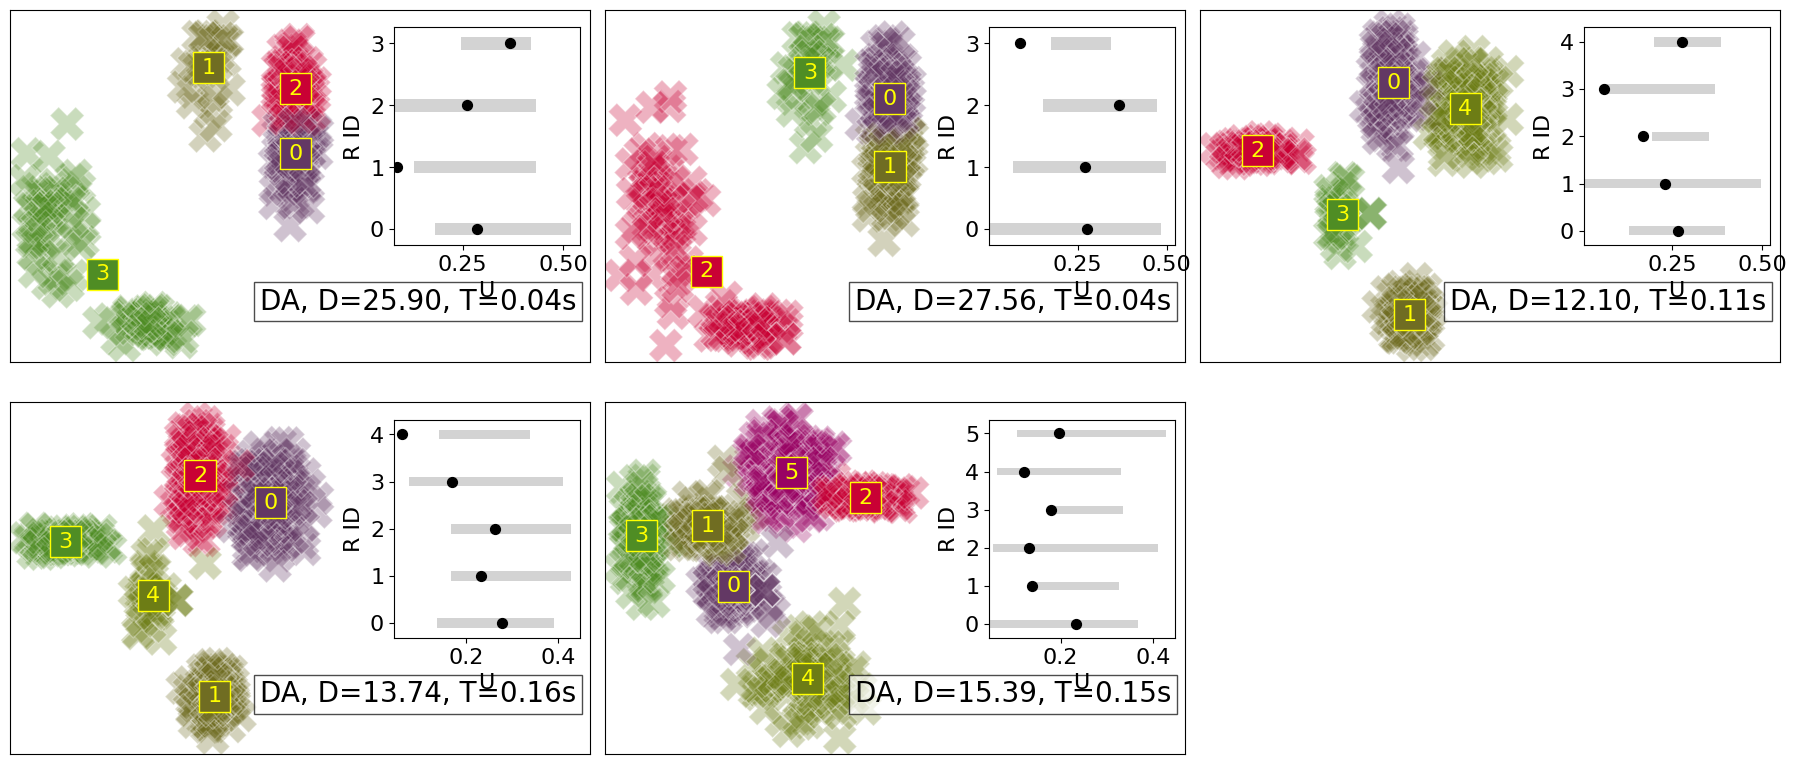

In [111]:

class_flp.plot_flp_sol_instances(
    DA_sol_instances,
    fontSize = 20,
    figSize = (6,4),
    savefig_opts=saveFig_opts,
    inset_coords=(0.65, 0.35, 0.32, 0.62),
    text_coords=(-10,-200),
    plotResTraj = False,
    plotCapacities=True
)

### Solve using our CBF approach

In [112]:
CBF_sol_instances = []
for i, flp in enumerate(flp_instances):
    print(f'\n------instance:{i}------')
    Y0 = np.random.uniform(-scale, scale, (flp.M,flp.d))
    P0 = np.random.uniform(0.0,1,(flp.N, flp.M)) + flp.P_eps
    P0 = P0/P0.sum(axis=1,keepdims=True)
    x0 = utils.YP2x(Y0, P0); print(f'x0\tshape:{x0.shape}')

    t0 = time.time()
    F_arr_cbf, b_arr_cbf, P_arr_cbf, Y_arr_cbf, t_compute_arr_cbf, cap_arr_cbf = flp.anneal_CBF_CLF(
        x0, beta0, betaf, beta_grow, p1, p2, gamma, 
        alpha_h, alpha_l, T_f, dt_init, dt_min, dt_max, 
        Ftol, xtol, allowPrint=True, printOptimizeIters=False)
    t1 = time.time()

    sol_instance = {
        'M_name':'Our',
        'n_facilities':flp.M,
        'n_resources':flp.N,
        'resource_locs':flp.resLoc,
        'upper_capacity':flp.C,
        'lower_capacity':flp.B,
        'F_arr':F_arr_cbf,
        'b_arr':b_arr_cbf,
        'P_arr':P_arr_cbf,
        'Y_arr':Y_arr_cbf,
        't_compute_arr':t_compute_arr_cbf,
        'cap_arr':cap_arr_cbf,
        'runtime':t1-t0
    }
    CBF_sol_instances.append(sol_instance)



------instance:0------
x0	shape:(1208,)
beta:2.000e-03	F:2.092e+02
beta:4.000e-03	F:2.095e+02
beta:8.000e-03	F:1.822e+02
beta:1.600e-02	F:1.238e+02
beta:3.200e-02	F:8.919e+01
beta:6.400e-02	F:6.170e+01
beta:1.280e-01	F:5.028e+01
beta:2.560e-01	F:4.146e+01
beta:5.120e-01	F:3.787e+01
beta:1.024e+00	F:3.549e+01
beta:2.048e+00	F:3.396e+01
beta:4.096e+00	F:3.303e+01
beta:8.192e+00	F:3.274e+01
beta:1.638e+01	F:3.240e+01
beta:3.277e+01	F:3.229e+01
beta:6.554e+01	F:3.224e+01
beta:1.311e+02	F:3.221e+01

------instance:1------
x0	shape:(1608,)
beta:2.000e-03	F:2.164e+02
beta:4.000e-03	F:2.166e+02
beta:8.000e-03	F:1.927e+02
beta:1.600e-02	F:1.268e+02
beta:3.200e-02	F:8.107e+01
beta:6.400e-02	F:5.139e+01
beta:1.280e-01	F:3.351e+01
beta:2.560e-01	F:2.347e+01
beta:5.120e-01	F:1.805e+01
beta:1.024e+00	F:1.533e+01
beta:2.048e+00	F:1.398e+01
beta:4.096e+00	F:1.330e+01
beta:8.192e+00	F:1.296e+01
beta:1.638e+01	F:1.279e+01
beta:3.277e+01	F:1.273e+01
beta:6.554e+01	F:1.266e+01
beta:1.311e+02	F:1.262e+01


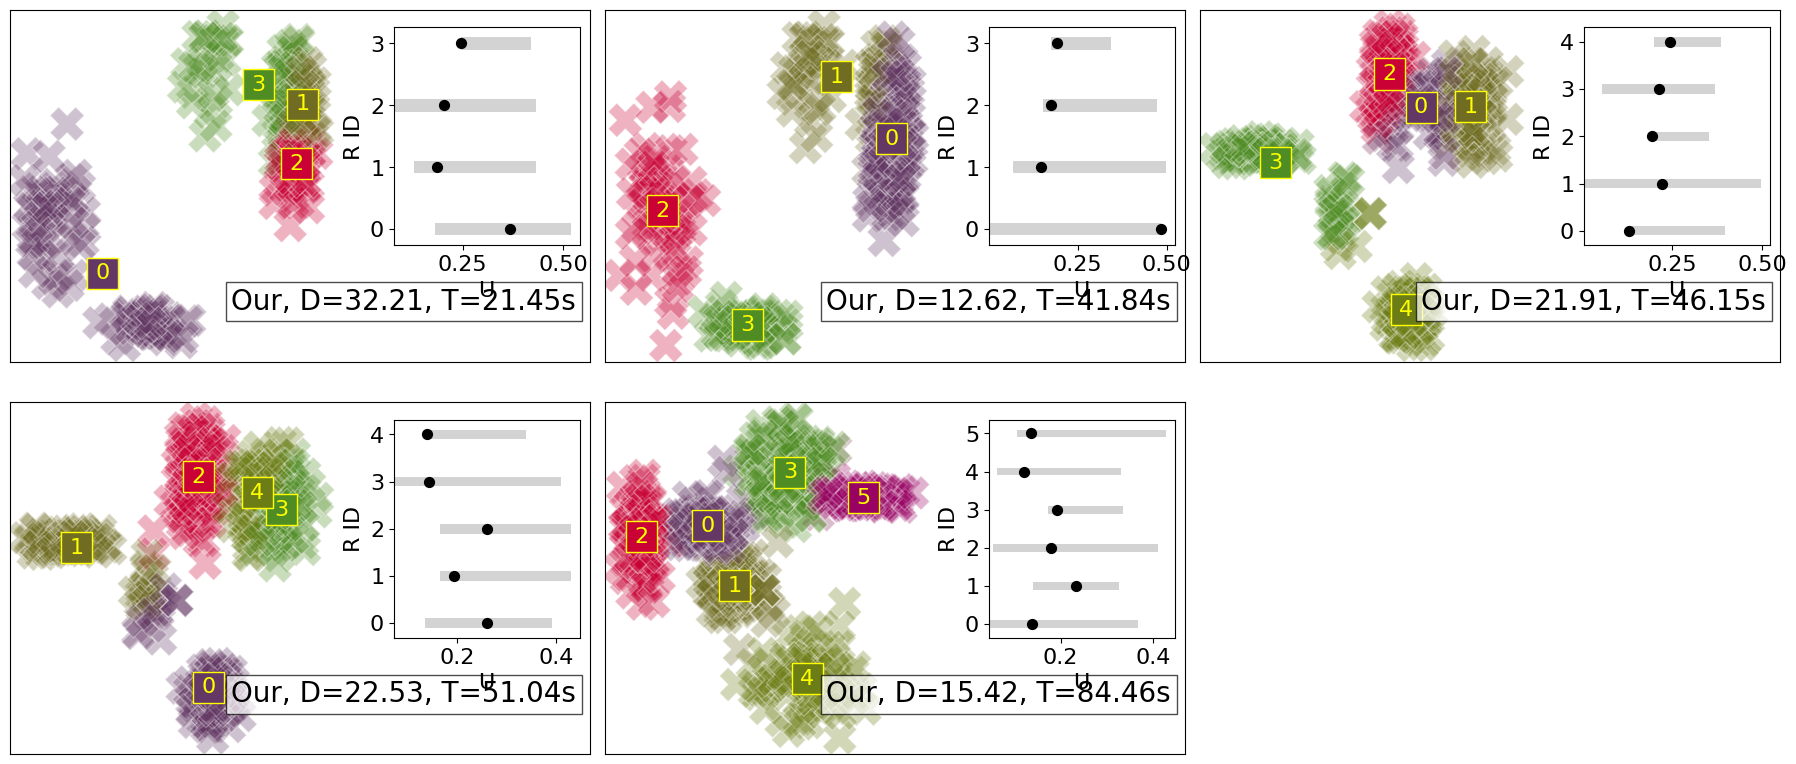

In [113]:
class_flp.plot_flp_sol_instances(
    CBF_sol_instances,
    fontSize = 20,
    figSize = (6,4),
    inset_coords=(0.65, 0.35, 0.32, 0.62),
    text_coords=(-10,-200),
    savefig_opts=saveFig_opts,
    plotResTraj = False,
    plotCapacities=True
)


### Solve using SGF approach

In [114]:
SGF_sol_instances = []
for i, flp in enumerate(flp_instances):
    print(f'\n------instance:{i}------')
    Y0 = np.random.uniform(-scale, scale,(flp.M,flp.d))
    P0 = np.random.uniform(0.0,1,(flp.N, flp.M)) + flp.P_eps
    P0 = P0/P0.sum(axis=1,keepdims=True)
    x0 = utils.YP2x(Y0, P0); print(f'x0\tshape:{x0.shape}')

    t0 = time.time()
    F_arr_sgf, b_arr_sgf, P_arr_sgf, Y_arr_sgf, t_compute_arr_sgf, cap_arr_sgf = flp.anneal_SGF(
        x0, beta0, betaf, beta_grow, alpha, kappa, T_f, dt_init, dt_min, dt_max, Ftol, xtol, allowPrint=True, printOptimizeIters=False)
    t1 = time.time()

    sol_instance = {
        'M_name':'SGF',
        'n_facilities':flp.M,
        'n_resources':flp.N,
        'resource_locs':flp.resLoc,
        'upper_capacity':flp.C,
        'lower_capacity':flp.B,
        'F_arr':F_arr_sgf,
        'b_arr':b_arr_sgf,
        'P_arr':P_arr_sgf,
        'Y_arr':Y_arr_sgf,
        't_compute_arr':t_compute_arr_sgf,
        'cap_arr':cap_arr_sgf,
        'runtime':t1-t0
    }
    SGF_sol_instances.append(sol_instance)




------instance:0------
x0	shape:(1208,)
beta:2.000e-03	F:2.094e+02
beta:4.000e-03	F:2.092e+02
beta:8.000e-03	F:2.088e+02
beta:1.600e-02	F:1.276e+02
beta:3.200e-02	F:8.511e+01
beta:6.400e-02	F:5.717e+01
beta:1.280e-01	F:4.320e+01
beta:2.560e-01	F:3.639e+01
beta:5.120e-01	F:3.263e+01
beta:1.024e+00	F:3.089e+01
beta:2.048e+00	F:3.000e+01
beta:4.096e+00	F:2.954e+01
beta:8.192e+00	F:2.930e+01
beta:1.638e+01	F:2.916e+01
beta:3.277e+01	F:2.909e+01
beta:6.554e+01	F:2.904e+01
beta:1.311e+02	F:2.900e+01

------instance:1------
x0	shape:(1608,)
beta:2.000e-03	F:2.166e+02
beta:4.000e-03	F:2.163e+02
beta:8.000e-03	F:2.159e+02
beta:1.600e-02	F:1.290e+02
beta:3.200e-02	F:8.038e+01
beta:6.400e-02	F:5.193e+01
beta:1.280e-01	F:3.778e+01
beta:2.560e-01	F:2.986e+01
beta:5.120e-01	F:2.623e+01
beta:1.024e+00	F:2.441e+01
beta:2.048e+00	F:2.349e+01
beta:4.096e+00	F:2.303e+01
beta:8.192e+00	F:2.280e+01
beta:1.638e+01	F:2.266e+01
beta:3.277e+01	F:2.259e+01
beta:6.554e+01	F:2.256e+01
beta:1.311e+02	F:2.254e+01


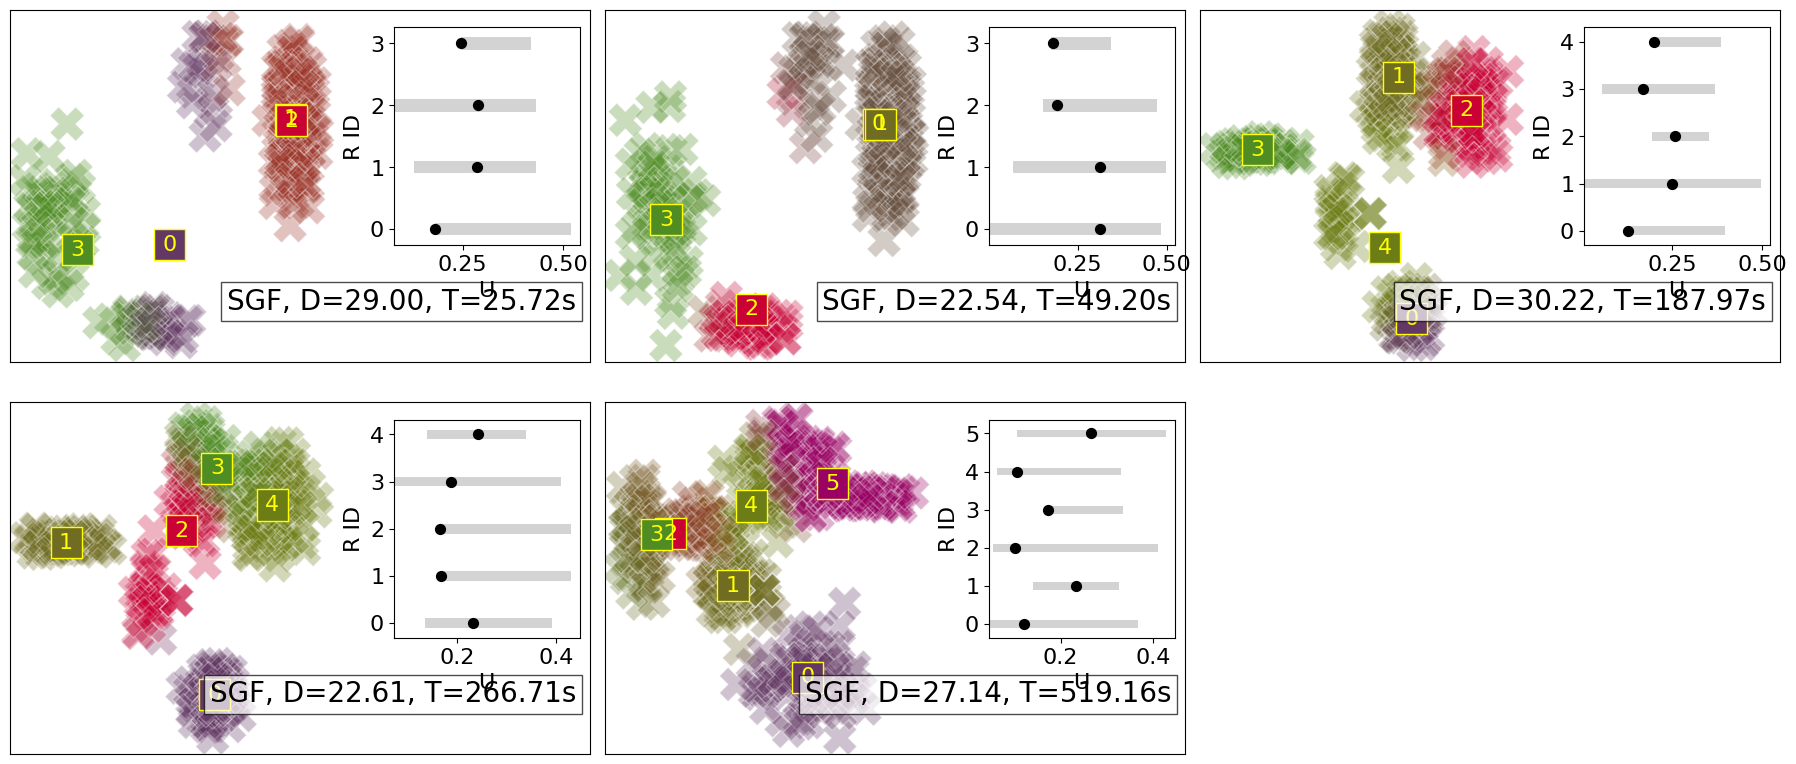

In [115]:
class_flp.plot_flp_sol_instances(
    SGF_sol_instances,
    fontSize = 20,
    figSize = (6,4),
    savefig_opts=saveFig_opts,
    inset_coords=(0.65, 0.35, 0.32, 0.62),
    text_coords=(-10,-200),
    plotResTraj = False,
    plotCapacities=True
)


### Solve using SLSQP

In [119]:
SLSQP_sol_instances = []
for i, flp in enumerate(flp_instances):
    print(f'\n------instance:{i}------')
    Y0 = np.random.uniform(-scale, scale,(flp.M,flp.d))
    P0 = np.random.uniform(0.0,1,(flp.N, flp.M)) + flp.P_eps
    P0 = P0/P0.sum(axis=1,keepdims=True)
    x0 = utils.YP2x(Y0, P0); print(f'x0\tshape:{x0.shape}')

    t0 = time.time()
    F_arr_slsqp, b_arr_slsqp, P_arr_slsqp, Y_arr_slsqp, t_compute_arr_slsqp, cap_arr_slsqp = flp.anneal_SLSQP(
        x0, beta0, betaf, beta_grow, Ftol*10)
    t1 = time.time()

    sol_instance = {
        'M_name':'SLSQP',
        'n_facilities':flp.M,
        'n_resources':flp.N,
        'resource_locs':flp.resLoc,
        'upper_capacity':flp.C,
        'lower_capacity':flp.B,
        'F_arr':F_arr_slsqp,
        'b_arr':b_arr_slsqp,
        'P_arr':P_arr_slsqp,
        'Y_arr':Y_arr_slsqp,
        't_compute_arr':t_compute_arr_slsqp,
        'cap_arr':cap_arr_slsqp,
        'runtime':t1-t0
    }
    SLSQP_sol_instances.append(sol_instance)




------instance:0------
x0	shape:(1208,)
beta:2.000e-03	F:2.096e+02
beta:4.000e-03	F:2.091e+02
beta:8.000e-03	F:2.090e+02
beta:1.600e-02	F:2.086e+02
beta:3.200e-02	F:1.045e+02
beta:6.400e-02	F:8.756e+01
beta:1.280e-01	F:5.620e+01
beta:2.560e-01	F:3.968e+01
beta:5.120e-01	F:3.029e+01
beta:1.024e+00	F:2.531e+01
beta:2.048e+00	F:2.385e+01
beta:4.096e+00	F:2.336e+01
beta:8.192e+00	F:2.312e+01
beta:1.638e+01	F:2.300e+01
beta:3.277e+01	F:2.295e+01
beta:6.554e+01	F:2.291e+01
beta:1.311e+02	F:2.290e+01

------instance:1------
x0	shape:(1608,)
beta:2.000e-03	F:2.169e+02
beta:4.000e-03	F:2.164e+02
beta:8.000e-03	F:2.161e+02
beta:1.600e-02	F:1.255e+02
beta:3.200e-02	F:8.746e+01
beta:6.400e-02	F:6.789e+01
beta:1.280e-01	F:5.811e+01
beta:2.560e-01	F:5.308e+01
beta:5.120e-01	F:3.680e+01
beta:1.024e+00	F:3.340e+01
beta:2.048e+00	F:3.243e+01
beta:4.096e+00	F:3.195e+01
beta:8.192e+00	F:3.170e+01
beta:1.638e+01	F:3.159e+01
beta:3.277e+01	F:3.155e+01
beta:6.554e+01	F:3.152e+01
beta:1.311e+02	F:3.152e+01


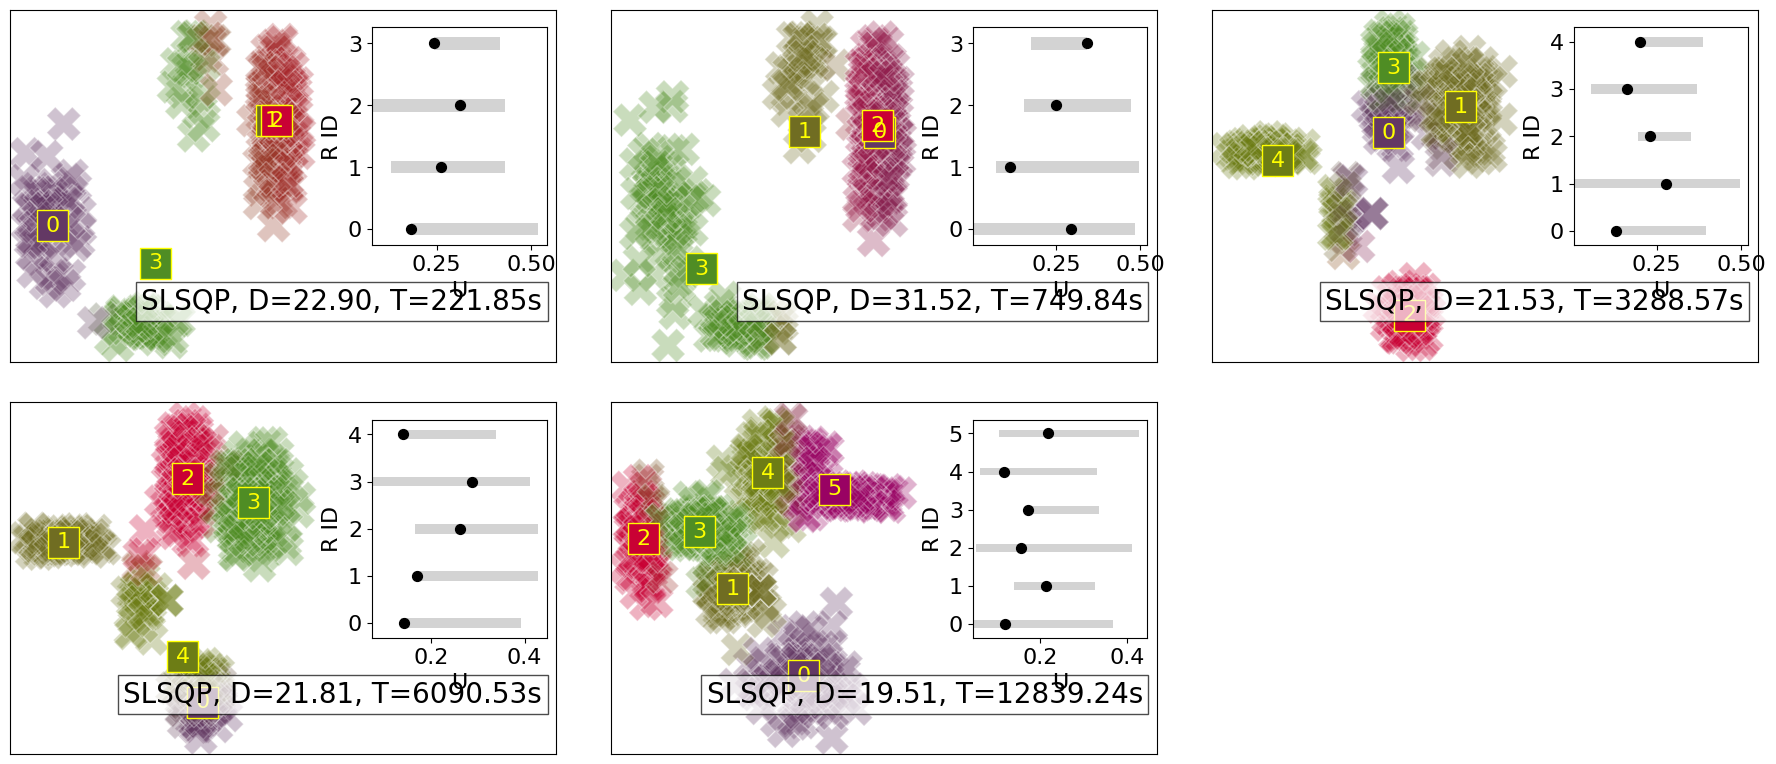

In [120]:
class_flp.plot_flp_sol_instances(
    SLSQP_sol_instances,
    fontSize = 20,
    figSize = (6,4),
    inset_coords=(0.65, 0.35, 0.32, 0.62),
    text_coords=(-10,-200),
    savefig_opts=saveFig_opts,
    plotResTraj = False,
    plotCapacities=True
)

### Solve using penalty based DA (DA-P)

In [116]:
DAC_sol_instances = []
for i, flp in enumerate(flp_instances):
    print(f'\n------instance:{i}------')
    Y0 = np.random.uniform(-scale, scale,(flp.M,flp.d))

    t0 = time.time()
    F_arr_dac, b_arr_dac, P_arr_dac, Y_arr_dac, t_compute_arr_dac, cap_arr_dac = flp.anneal_DA_C(
        Y0, beta0, betaf, beta_grow, b1_min, b1_max, b1_grow, theta, n_iters, D_tol)
    t1 = time.time()

    sol_instance = {
        'M_name':'DAP',
        'n_facilities':flp.M,
        'n_resources':flp.N,
        'resource_locs':flp.resLoc,
        'upper_capacity':flp.C,
        'lower_capacity':flp.B,
        'F_arr':F_arr_dac,
        'b_arr':b_arr_dac,
        'P_arr':P_arr_dac,
        'Y_arr':Y_arr_dac,
        't_compute_arr':t_compute_arr_dac,
        'cap_arr':cap_arr_dac,
        'runtime':t1-t0
    }
    DAC_sol_instances.append(sol_instance)




------instance:0------
cons_violation: [-0.268 -0.182 -0.182 -0.169]
b:2.000e-03	b1_min,b1_max:(1e-05, 0.001)	F:209.0055
cons_violation: [-0.268 -0.182 -0.182 -0.169]
b:4.000e-03	b1_min,b1_max:(2e-05, 0.002)	F:209.0055
cons_violation: [-0.245 -0.189 -0.189 -0.176]
b:8.000e-03	b1_min,b1_max:(4e-05, 0.004)	F:179.1456
cons_violation: [-0.172 -0.214 -0.214 -0.201]
b:1.600e-02	b1_min,b1_max:(8e-05, 0.008)	F:122.1963
cons_violation: [-0.152 -0.22  -0.22  -0.207]
b:3.200e-02	b1_min,b1_max:(0.00016, 0.016)	F:82.4770
cons_violation: [-0.152 -0.341 -0.16  -0.148]
b:6.400e-02	b1_min,b1_max:(0.00032, 0.032)	F:59.1090
cons_violation: [-0.151 -0.345 -0.157 -0.146]
b:1.280e-01	b1_min,b1_max:(0.00064, 0.064)	F:43.6007
cons_violation: [-0.151 -0.345 -0.157 -0.147]
b:2.560e-01	b1_min,b1_max:(0.00128, 0.128)	F:35.5895
cons_violation: [-0.151 -0.345 -0.151 -0.152]
b:5.120e-01	b1_min,b1_max:(0.00256, 0.256)	F:31.0064
cons_violation: [-0.151 -0.345 -0.147 -0.156]
b:1.024e+00	b1_min,b1_max:(0.00512, 0.512)	

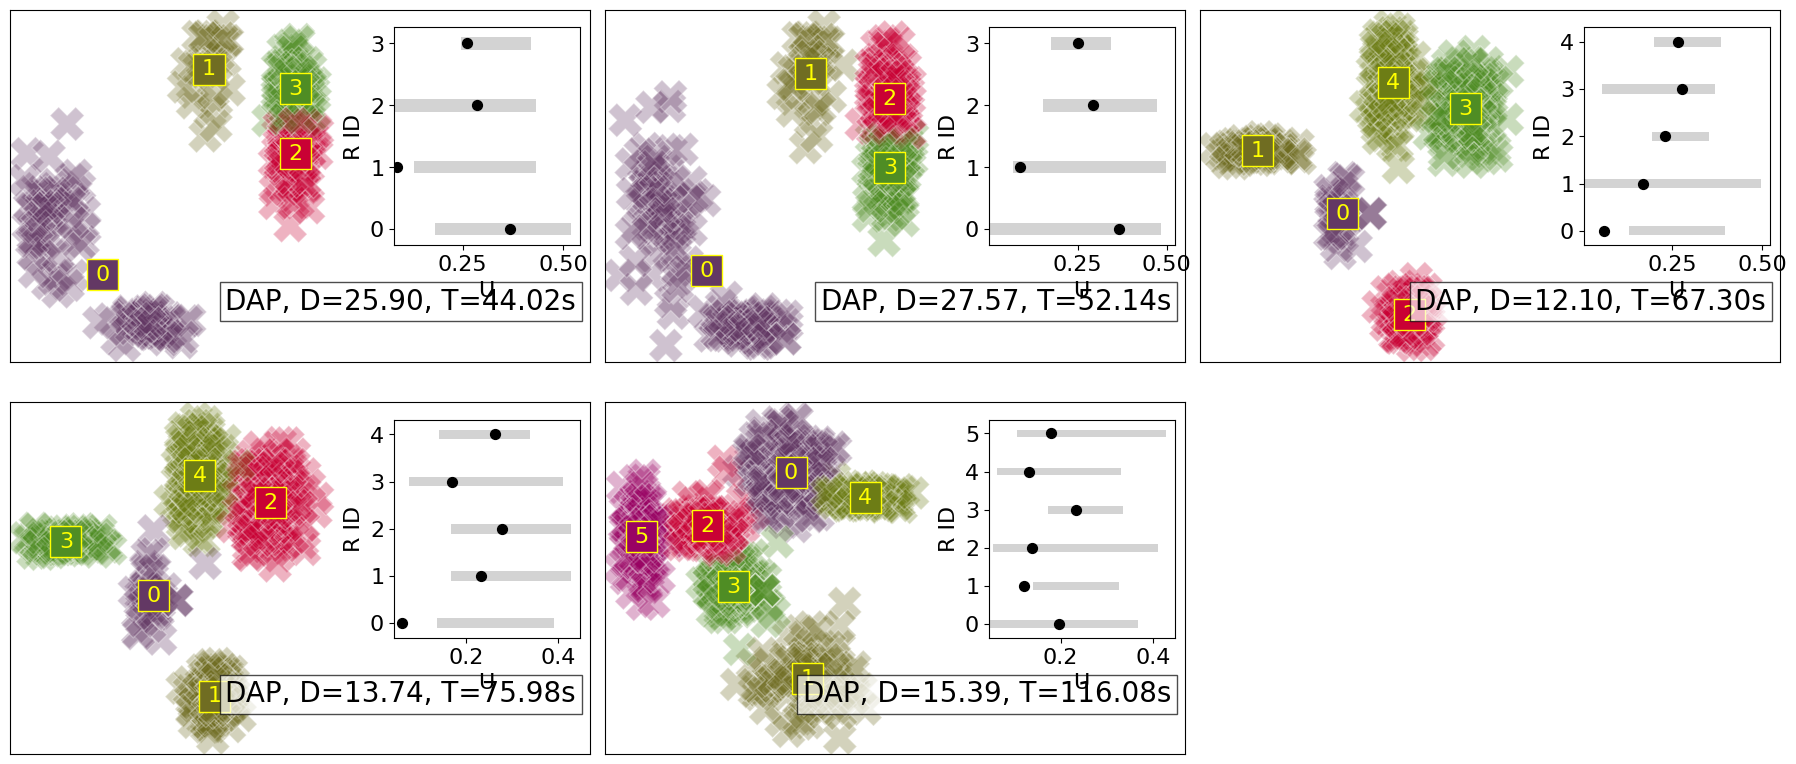

In [117]:
class_flp.plot_flp_sol_instances(
    DAC_sol_instances,
    fontSize = 20,
    figSize = (6,4),
    inset_coords=(0.65, 0.35, 0.32, 0.62),
    text_coords=(-10,-200),
    savefig_opts=saveFig_opts,
    plotResTraj = False,
    plotCapacities=True
)



In [121]:
### Save Data
all_approaches = {
    "DA": DA_sol_instances,
    "CBF": CBF_sol_instances,
    "SGF": SGF_sol_instances,
    "SLSQP": SLSQP_sol_instances,
    "DAC": DAC_sol_instances,
}
Nmin = min(N_range)
Mmin = min(M_range)
Nmax = max(N_range)
Mmax = max(M_range)
filename = f'N_{Nmin}_{Nmax}_M_{Mmin}_{Mmax}_n_instances_{n_instances}_seed_{seed}.pkl'
dir = 'compare_annealing_data/' + filename
print('data file directory:\n'+dir)

with open(dir, 'wb') as f:
    pickle.dump(all_approaches, f)

data file directory:
compare_annealing_data/N_300_700_M_4_6_n_instances_5_seed_20.pkl
